## Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
data_dir = './../data'
progbar = utils.ProgressBar(elapsed_time=True)
progbar.update_progress(0)

[0:00:00][----------] 0.00% 

In [147]:
profile = pd.read_csv(os.path.join(data_dir, 'profile.csv'), sep=';', parse_dates=["became_member_on"])
df_offers = pd.read_csv(os.path.join(data_dir, 'df_offers.csv'), sep=';', parse_dates=["became_member_on"])
# transcript = pd.read_json(os.path.join(data_dir, 'transcript.json'), lines=True)
df_offers.head()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,social,web,bogo,informational,discount,offered_reward,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1,24,0,NaN,0.00,1,0,...,1,0,0,1,0,0,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1,36,0,NaN,0.00,1,0,...,0,1,0,1,0,0,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1,48,1,6.0,8.57,0,1,...,1,1,1,0,0,5,33.0,2017-04-21,M,72000.0
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1,36,1,24.0,14.11,0,1,...,1,1,0,0,1,2,33.0,2017-04-21,M,72000.0
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1,36,1,0.0,10.27,0,1,...,0,1,0,0,1,2,33.0,2017-04-21,M,72000.0


## Preprocessing

Creating proper columns for the clustering algorithm

In [28]:
profile["days_since_subscription"] = (pd.Timestamp.today()-profile.became_member_on).dt.days

In [30]:
profile.head()

,age,became_member_on,gender,person,income,days_since_subscription
0,54.393524,2017-02-12,O,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1150
1,55.000000,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,997
2,54.393524,2018-07-12,O,38fe809add3b4fcf9315a9694bb96ff5,64000.0,635
3,75.000000,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1064
4,54.393524,2017-08-04,O,a03223e636434f42ac4c3df47e8bac43,64000.0,977


In [33]:
profile["gender_clean"] = profile.gender.map({"O": 0, "M": 1, "F": -1})

## Cross Validation Analysis

Based on the average silhoutte score from the clustering algorithm, we want to find out what are the candidate number of clusters for a post-training analysis. 

In [93]:
fit_columns = ["age", "gender_clean", "income", "days_since_subscription"]
silhouette_avg = list()
n_clusters = np.arange(2, 11, 1)
X = profile[fit_columns].values
df_silhouette_avg = pd.DataFrame(columns = ["fold", "n_cluster", "train_silhouette", "test_silhouette"])
trained_models = list()
fold = -1

sss = StratifiedShuffleSplit(n_splits=5)

for train_index, test_index in sss.split(X, np.zeros(len(X))):        
    fold += 1
    print ("Running analysis on fold {}".format(fold))
    X_train, X_test = X[train_index], X[test_index]
    for n_cluster in n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        test_silhouette = silhouette_score(X_test, model.predict(X_test))

        row = [fold, n_cluster, train_silhouette, test_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row
    

Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


Plotting mean and standard deviation of silhouette score for each fold

Text(0, 0.5, 'Silhouette Score')

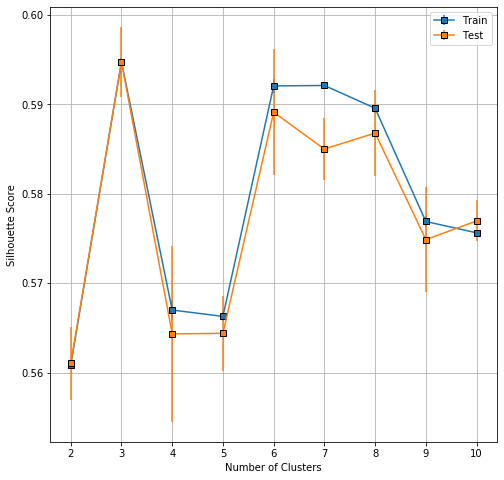

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
df_plot = df_silhouette_avg.groupby("n_cluster")
for set_label in ["train", "test"]:
    ax.errorbar(df_plot.mean().index, 
                df_plot.mean()[set_label + "_silhouette"].values, 
                df_plot.std()[set_label + "_silhouette"].values, label=set_label.title(),
               marker='s', mec='black')
ax.grid(True)
ax.legend()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

Based on this plot, we can infer that `3` or `6` clusters are probably recommended for making data-drive customer profiles. In order to make a final decision, we shall analyse each variable, including those ones that were not user for training and have business value. 

To be continued

In [116]:
chosen_n_clusters = [3, 6]
for n_cluster in chosen_n_clusters:
    model = KMeans(n_clusters=n_cluster, random_state=0).fit(X)    
    profile["cluster_" + str(n_cluster)] = model.predict(X)

In [148]:
df_offers = pd.merge(df_offers, 
                     profile[["person", "days_since_subscription"] + ["cluster_" + str(n_cluster) for n_cluster in chosen_n_clusters]], 
                     how="inner", on="person")

In [149]:
df_offers.head()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,informational,discount,offered_reward,age,became_member_on,gender,income,days_since_subscription,cluster_3,cluster_6
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1,24,0,NaN,0.00,1,0,...,1,0,0,33.0,2017-04-21,M,72000.0,1082,2,5
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1,36,0,NaN,0.00,1,0,...,1,0,0,33.0,2017-04-21,M,72000.0,1082,2,5
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1,48,1,6.0,8.57,0,1,...,0,0,5,33.0,2017-04-21,M,72000.0,1082,2,5
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1,36,1,24.0,14.11,0,1,...,0,1,2,33.0,2017-04-21,M,72000.0,1082,2,5
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1,36,1,0.0,10.27,0,1,...,0,1,2,33.0,2017-04-21,M,72000.0,1082,2,5


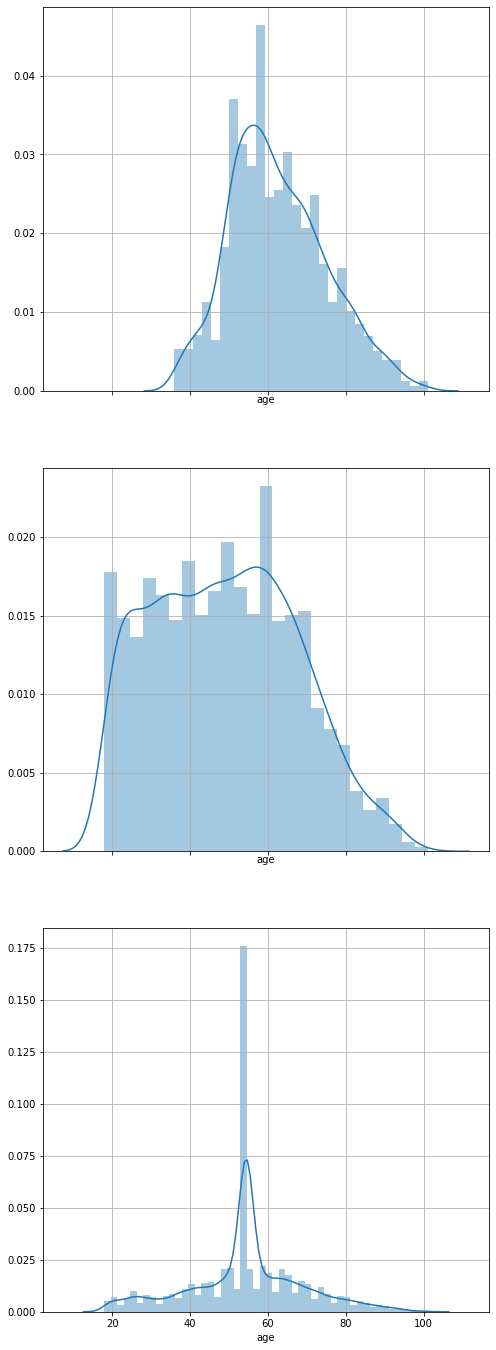

In [155]:
n_cluster = 3
fig, axes = plt.subplots(nrows=n_cluster, ncols=1, figsize=(8, n_cluster*8), sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    df_temp = profile[profile["cluster_" + str(n_cluster)] == i].copy()
    sns.distplot(df_temp.dropna()['age'], ax=ax)
    ax.grid(True)